## PyTorch Workflow

1. Obtendo dados
2. Construção do modelo
3. Fitting
4. Predições e evaluações
5. Salvando e carregando o modelo
6. Juntando tudo

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

### Obtendo dados

Machine learning é um jogo de duas partes:

1. Obter uma representação numérica para os dados; e
2. Construir um modelo que encontra padrões na representação numérica.

Para demonstrar isso, iremos criar um conjunto de dados _conhecido_ utilizando uma fórmula.

Vamos construir uma linha reta com parâmetros conhecidos.

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias # y = ax + b

In [3]:
print(X[:5], len(X))
print(Y[:5], len(Y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]]) 50
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]]) 50


Separando em datasets de treinamento e teste:

In [4]:
training_split = 40

X_TRAIN, Y_TRAIN = X[:training_split], Y[:training_split]
X_TEST, Y_TEST = X[training_split:], Y[training_split:]

print(len(X_TRAIN), len(X_TEST))
print(len(Y_TRAIN), len(Y_TEST))

40 10
40 10


In [5]:
def plot(train_data=X_TRAIN, train_labels=Y_TRAIN, test_data=X_TEST, test_labels=Y_TEST, predictions=None):
    plt.figure(figsize=(10, 7))

    # Dados de treinamento em azul:
    plt.scatter(train_data, train_labels, c='blue', s=4, label='Training data')

    # Dados de teste em vermelho:
    plt.scatter(test_data, test_labels, c='red', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='green', s=4, label='Predictions')

    plt.legend(prop={'size': 14})

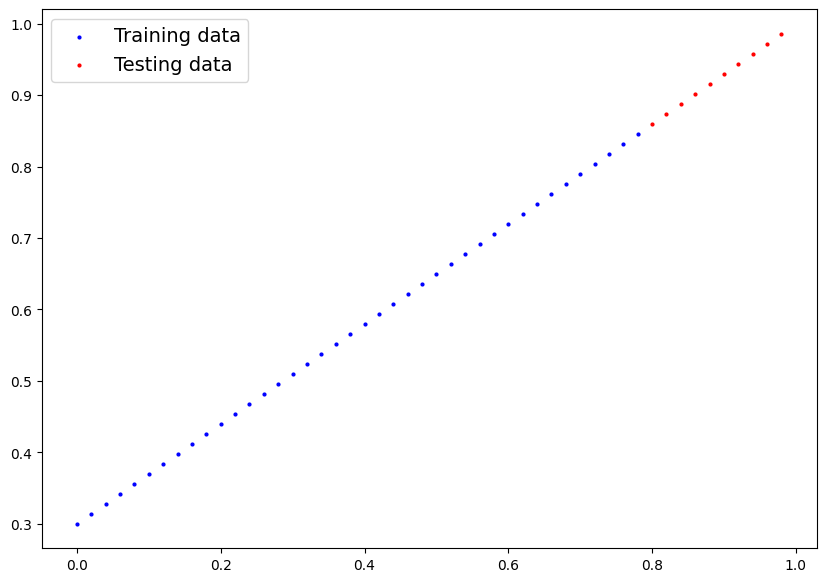

In [6]:
plot()

### Construção do modelo

O que o modelo faz:

* Inicia com valores aleatórios (`weight` e `bias`); e
* Observa os dados de treinamento e ajusta os valores aleatórios para melhor representar os valores ideais (desconhecidos pelo modelo).

Como ele faz isso? Através de dois algoritmos principais:

* Gradient descent
* Backpropagation

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x: torch.Tensor):
        return self.weights * x + self.bias # y = ax + b

In [8]:
torch.manual_seed(42)

linear_regression_model = LinearRegressionModel()

print(list(linear_regression_model.parameters()))
print(linear_regression_model.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


### Fazendo predições

Para verificar a capacidade preditiva de nosso modelo, vejamos como ele prediz `Y_TEST` baseando-se em `X_TEST`.

Quando passamos dados pelo modelo, ele irá executar o método `forward`.

In [9]:
with torch.inference_mode():
    predictions = linear_regression_model(X_TEST)

print(predictions)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


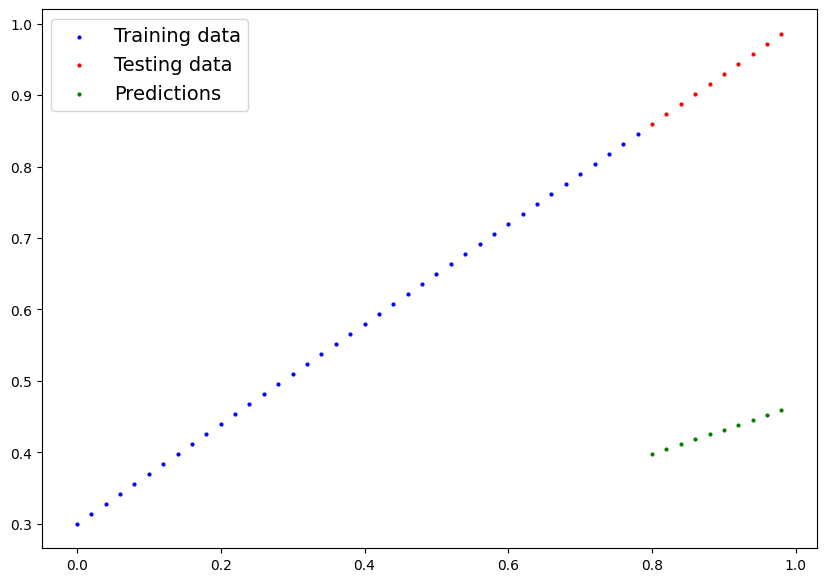

In [10]:
plot(predictions=predictions)

### Treinamento do modelo

O objetivo do treinamento é fazer com que os parâmetros do modelo saiam de um estado desconhecido (que pode ser aleatório) para um estado conhecido. Ou, em outras palavras, de uma representação pobre dos dados para uma representação melhor.

Um modo de averiguar o quão boas ou ruins as predições do modelo estão é através de uma _loss function_.

Coisas necessárias para construir um modelo:

* _Loss function_: uma função para medir o quão errado o modelo está (menor é melhor).
* _Optimizer_: ajusta os parâmetros do modelo com base no retorno da _loss function_.
* _Training loop_: específico do PyTorch.
* _Test loop_: específico do PyTorch.

Nota: _loss function_ também pode ser chamada de _cost function_ ou _criterion_, dependendo do contexto e área. Neste estudo, chamaremos simplesmente de _loss function_.

In [11]:
loss_function = nn.L1Loss() # torch.mean(torch.abs(y_pred - y_test))

optimizer = torch.optim.SGD(params=linear_regression_model.parameters(), lr=0.01) # lr = learning rate

**Pergunta:** Qual _loss function_ e _optimizer_ devo usar?

**Resposta:** Isso depende de cada caso. Por exemplo, para problemas de regressão (como esse), uma _loss function_ `nn.L1Loss()` e _optimizer_ `torch.optim.SGD()` são suficientes. Porém, para outros tipos de problemas, como classificar se uma foto é de um cachorro ou gato, provavelmente usaríamos `nn.BCELoss()` (_binary cross entropy loss_).

![mean_absolute_error](../docs/mean_absolute_error.png)

### Construindo os loops de treinamento e teste

O que é necessário:

1. Iterar pelo dataset;
2. _Forward propagation_: mover os dados pelo método `forward` do modelo para fazer predições;
3. Calcular o erro: comparar as predições com a verdade;
4. _Optimizer zero grad_: 
5. _Backpropagation_: percorrer o modelo "de trás para frente" para calcular os gradientes de cada parâmetro do modelo com relação à perda;
6. Otimização: usar o _optimizer_ para ajustar os parâmetros de nosso modelo para tentar melhorar o erro (também chamado de _gradient descent_).

![gradient_descent](../docs/gradient_descent.png)

In [12]:
epochs = 200

# Variáveis para monitorar a performance do modelo:
history_epoch = []
history_train_loss = []
history_test_loss = []

# 1. Iterar pelo dataset:
for epoch in range(epochs):
    # Configura todos os parâmetros que utilizam gradient descent:
    linear_regression_model.train()

    # 2. Forward propagation:
    y_pred = linear_regression_model(X_TRAIN)

    # 3. Calcular o erro:
    loss = loss_function(y_pred, Y_TRAIN)

    # 4. Optimizer zero grad:
    optimizer.zero_grad()

    # 5. Backpropagation:
    loss.backward()

    # 6. Otimização:
    optimizer.step()

    # Desativa o tracking dos gradientes:
    linear_regression_model.eval()

    state = linear_regression_model.state_dict()

    if epoch % 10 == 0:
        history_epoch.append(epoch)
        history_train_loss.append(loss)

        print(f'[TRAINING] Epoch {epoch}: loss {loss:.6f}, weights {state["weights"][0]:.3f}, bias {state["bias"][0]:.3f}')

    # Testando o modelo (note que estamos usando o dataset de testes):
    with torch.inference_mode():
        # 1. Forward propagation:
        y_pred = linear_regression_model(X_TEST)

        # 2. Calcular o erro:
        loss = loss_function(y_pred, Y_TEST)

        state = linear_regression_model.state_dict()

        if epoch % 10 == 0:
            history_test_loss.append(loss)

            print(f'[TESTING] Epoch {epoch}: loss {loss:.6f}')

[TRAINING] Epoch 0: loss 0.312881, weights 0.341, bias 0.139
[TESTING] Epoch 0: loss 0.481065
[TRAINING] Epoch 10: loss 0.197671, weights 0.380, bias 0.239
[TESTING] Epoch 10: loss 0.346355
[TRAINING] Epoch 20: loss 0.089087, weights 0.418, bias 0.333
[TESTING] Epoch 20: loss 0.217297
[TRAINING] Epoch 30: loss 0.053149, weights 0.451, bias 0.377
[TESTING] Epoch 30: loss 0.144640
[TRAINING] Epoch 40: loss 0.045438, weights 0.475, bias 0.387
[TESTING] Epoch 40: loss 0.113610
[TRAINING] Epoch 50: loss 0.041679, weights 0.494, bias 0.384
[TESTING] Epoch 50: loss 0.099199
[TRAINING] Epoch 60: loss 0.038189, weights 0.512, bias 0.379
[TESTING] Epoch 60: loss 0.088866
[TRAINING] Epoch 70: loss 0.034761, weights 0.529, bias 0.372
[TESTING] Epoch 70: loss 0.080594
[TRAINING] Epoch 80: loss 0.031324, weights 0.546, bias 0.365
[TESTING] Epoch 80: loss 0.072321
[TRAINING] Epoch 90: loss 0.027887, weights 0.563, bias 0.357
[TESTING] Epoch 90: loss 0.064736
[TRAINING] Epoch 100: loss 0.024459, weigh

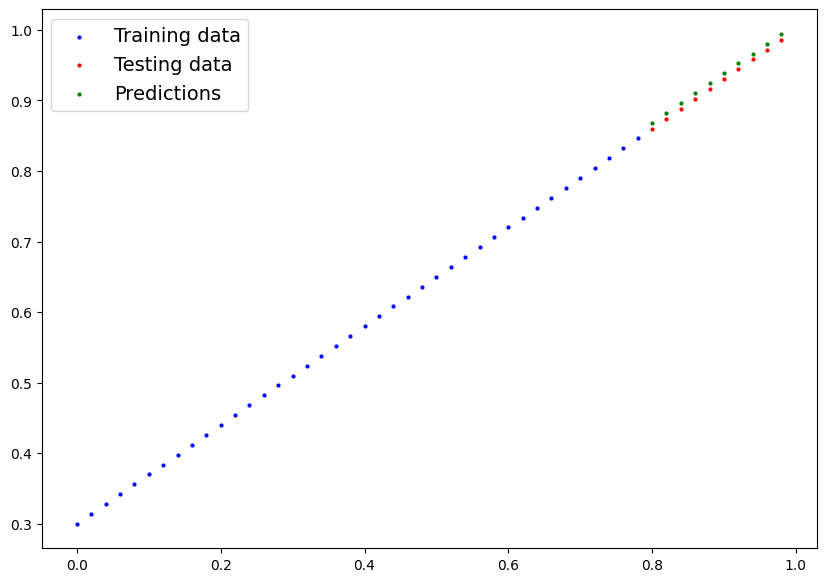

In [13]:
with torch.inference_mode():
    y_pred = linear_regression_model(X_TEST)

    plot(predictions=y_pred)

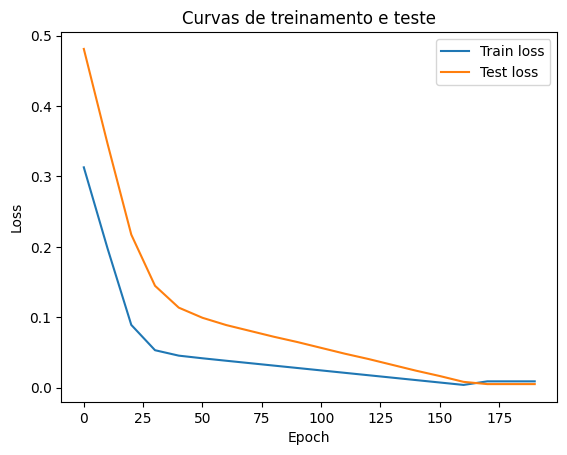

In [18]:
plt.plot(history_epoch, torch.tensor(history_train_loss).numpy(), label='Train loss')
plt.plot(history_epoch, history_test_loss, label='Test loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.title('Curvas de treinamento e teste')

plt.show()

![pytorch_song](../docs/pytorch_song.png)